In [32]:
import ticktack
import pandas
from jax.numpy import arange, sin, pi, array, greater, less, equal, where, mean
from jax import jacrev, grad
from scipy.optimize import minimize
import matplotlib.pyplot as plt

The basic question is what is the probability of detecting consecutive events based on the distribution of the data. The first step then will be to determine the distribution of the data. This will be done be resampling the points after the event has been removed.

In [4]:
def sine(t, p):
    """
    Generates a simple sinusoidal production function. p is an array containing the amplitude of the production sinusoid and the phase of the sinusoid.
    """
    return 1.88 + p[0] * 1.88 * sin(2 * pi / 11 * t + p[1])

def rect(t, p):
    """
    Generates a rectangular miyake event. p is an array that contains the start and end times as well as the height of the production function 
    """
    condition = equal(greater(t, p[0]), less(t, p[1]))
    return where(condition, p[3], 0.0)

def prod(t, *args):
    amplitude, phase, start, end, height = tuple(args)
    sine_params = array([amplitude, phase])
    rect_params = array([start, end, height])
    return sine(t, sine_params) + rect(t, rect_params)

In [28]:
annual_samples = 48                  # 4 samples per month
sample_times = arange(-360.0, 790.0)  # Times at which to collect samples
growth_bools = array([0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0])
params = array([1.0, 1.25, 772.0, 775.0, 40.0])

In [22]:
cbm = ticktack.load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()

In [23]:
miyake = pandas.read_csv("Miyake12.csv", sep=" ")   # Reading the data from the Miyake 2012
DC14 = array([*miyake.d14c])                        # JAX array for manipulation
SDC14 = array([*miyake.sig_d14c])                   # JAx array for manipulation 

So below is where I minimize the $\chi^{2}$ statistic using an ODE integration style approach.

In [35]:
def log_likelihood(params): 
    model, steady_state = cbm.run(sample_times, annual_samples,     # Running the carbon box model
        production=prod, steady_state_production=1.88, args=params)

    troposphere = cbm.bin_data( # Bins the data into annual values
        model[:, 2],    # Selecting only the years that I have data for 
        annual_samples, # Number of samples per year 
        sample_times,   # Times to return the binned values for 
        growth_bools    # Boolean mask of growth seasons
    )
    
    troposphere = troposphere[-29:-1]   # slicing only the period of interest 
    troposphere = 1000 * (troposphere - steady_state[2]) / steady_state[2]  # Normalising the data 
    troposphere = troposphere + mean(array([*miyake["d14c"][0:4]])) # Offseting the data to match 
    return 0.5 * sum(((DC14 - troposphere) / SDC14) ** 2)   # Log likelhood as chi-squared

In [38]:
test = minimize(log_likelihood, params, method='Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: 35.326843
         Iterations: 433
         Function evaluations: 731


In [ ]:
sample_times = arange(-360.0, 810.0)

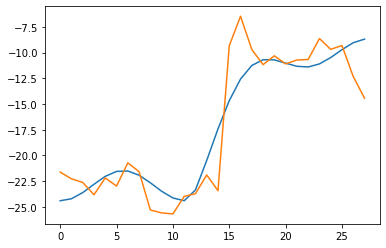

In [50]:
model, steady_state = cbm.run(sample_times, annual_samples,     # Running the carbon box model
        production=prod, steady_state_production=1.88, args=test.x)

troposphere = cbm.bin_data(model[:, 2], annual_samples, sample_times, growth_bools)
troposphere = (troposphere - steady_state[2]) / steady_state[2] * 1000
troposphere = troposphere + mean(DC14[1:4])
plt.plot(troposphere[-29:-1])
plt.plot(DC14)

In [38]:
mcmc_model = ticktack.fitting.SingleFitter(cbm)
mcmc_model.load_data("Miyake12.csv")
mcmc_model.prepare_function(model=prod)

In [ ]:
sampler = mcmc_model.MarkovChainSampler(params, likelihood = mcmc_model.log_likelihood)

In [ ]:
labels = ["Amplitude ($atoms/cm^2/s$)", "Phase (yr)", "Start Date (yr)", "End Date (yr)", "Height ($atoms/cm^2/s$)"]
fig = mcmc_model.chain_summary(sampler, 20, labels=labels)

In [ ]:
mcmc_model.plot_recovery(sampler, 20)

So from here the plan is to first of all find the ideal sinusoidal model based on the data points until the event. I then run this model and subtract it away from the data allowing me to determine the signal to noise ratio of the entire data instead of a subset. Then I simulate a series of events and minimize the $\chi^{2}$ to determine the best fitting rectangular event. In addition I will have some criterion for the $\chi^{2}$ as to when an event is detected allowing me to identify the minimum parameters of the event. I will then plot a contour plot of the $\chi^{2}$ in the 2 dimensional parameter space. This will be the final product.

The next step is to minimize the $\chi^{2}$. After working so hard to get the `mcmc` I'm going to try and use this. The problem is because I was not using ticktack I can now immensly simplify the code by using the `SingleFitter` implementations provided by Q.

To minimize the $\chi^{2}$ statistic I will need to isolate the data before the event and use this to determine the $\sin$ parameters. This is going to require modifications to the `prod` function and also will require a better understanding of the plotting backend.

It will be easiest to modify the file. It is nice I must say to have got fucking nowhere all day. I'm going to go and pack now after merging these changes on github.